In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from statsmodels.formula.api import ols
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('violent_crime.csv')

In [3]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

In [4]:
df.head(3)

,case_number,date,block,primary_type,unique_id,zip_code,ward,community_area,street_outreach_organization,area,district,beat,age,sex,race,fbi_cd,fbi_descr,iucr_cd,iucr_secondary,month,day_of_week,hour,latitude,longitude,location
0,HZ100096,01/01/2016 02:04:00 AM,4600 S ST LAWRENCE,FATAL SHOOTING,HOM-HZ100096-1,60653,4,GRAND BOULEVARD,None,1,2,221,20 - 29,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,2,41.810127,-87.611604,POINT (-87.611604058699 41.810126904142)
1,HZ100342,01/01/2016 06:39:00 AM,1900 W GARFIELD BLVD,FATAL SHOOTING,HOM-HZ100342-1,60609,16,NEW CITY,PBMR New City,1,9,932,30 - 39,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,6,41.794218,-87.673175,POINT (-87.67317465388 41.794218345858)
2,HZ101042,01/01/2016 10:06:00 PM,6100 S SANGAMON ST,FATAL SHOOTING,HOM-HZ101042-1,60621,16,ENGLEWOOD,TADC Englewood | READI 60621,1,7,712,30 - 39,M,BLK,01A,HOMICIDE - 1ST OR 2ND DEGREE (INDEX),0110,FIRST DEGREE MURDER,1,6,22,41.782338,-87.647905,POINT (-87.64790465388 41.782338345858)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20036 entries, 0 to 20035
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   case_number                   20036 non-null  object 
 1   date                          20036 non-null  object 
 2   block                         20036 non-null  object 
 3   primary_type                  20036 non-null  object 
 4   unique_id                     20036 non-null  object 
 5   zip_code                      20036 non-null  int64  
 6   ward                          20036 non-null  int64  
 7   community_area                20036 non-null  object 
 8   street_outreach_organization  20036 non-null  object 
 9   area                          20036 non-null  int64  
 10  district                      20036 non-null  int64  
 11  beat                          20036 non-null  int64  
 12  age                           19801 non-null  object 
 13  s

In [6]:
df['age'].fillna('UNKNOWN', inplace=True)
df['sex'].fillna('UNKNOWN', inplace=True)
df['race'].fillna('(NOT PROVIDED)', inplace=True)

In [7]:
df['iucr_secondary'].replace(' -', ':', inplace=True, regex=True)
df['sex'].replace(['UNKNOWN','X', '(NOT PROVIDED)'], 'SEX_UNKNOWN', inplace=True)

In [8]:
df['sex'].unique()

array(['M', 'F', 'SEX_UNKNOWN'], dtype=object)

In [9]:
df['iucr_secondary'].value_counts()

AGGRAVATED: HANDGUN                           15415
FIRST DEGREE MURDER                            3599
ARMED: HANDGUN                                  376
ATTEMPT: ARMED-HANDGUN                          192
AGGRAVATED: OTHER FIREARM                       123
AGGRAVATED DOMESTIC BATTERY: HANDGUN             92
ATTEMPT ARMED: HANDGUN                           86
SECOND DEGREE MURDER                             38
AGGRAVATED VEHICULAR HIJACKING                   31
AGGRAVATED POLICE OFFICER: HANDGUN               21
AGGRAVATED PO: HANDGUN                           18
AGGRAVATED                                        8
INVESTIGATION                                     5
VEHICULAR HIJACKING                               4
ATTEMPT AGGRAVATED                                4
AGGRAVATED POLICE OFFICER: OTHER FIREARM          3
ATTEMPT: AGGRAVATED                               3
ARMED: OTHER FIREARM                              3
ATTEMPT ARMED: OTHER FIREARM                      3
ARMED: OTHER

In [10]:
def help_available(string):
    if string == 'None':
        return 'no'
    else:
        return 'yes'

In [11]:
df['so_yes_no'] = df['street_outreach_organization'].map(help_available)
df['so_yes_no']

0         no
1        yes
2        yes
3        yes
4        yes
        ... 
20031     no
20032    yes
20033    yes
20034     no
20035     no
Name: so_yes_no, Length: 20036, dtype: object

In [12]:
df['street_outreach_organization'].value_counts()

None                                                         5100
READI 60644 | INVC Austin                                    1132
UCAN North Lawndale | READI 60623                             875
TADC Englewood | READI 60621                                  864
ALSO Humboldt Park                                            825
                                                             ... 
READI 60623 | New Life Centers Brighton Park                    1
TADC Englewood | READI 60621 | Acclivus Washington Park         1
UCAN North Lawndale | READI 60623 | Enlace South Lawndale       1
New Life Centers South Lawndale                                 1
SWOP Gage Park | READI 60631                                    1
Name: street_outreach_organization, Length: 78, dtype: int64

In [13]:
df['so_yes_no'].value_counts()

yes    14936
no      5100
Name: so_yes_no, dtype: int64

In [14]:
df['sex'].value_counts()

M              17261
F               2530
SEX_UNKNOWN      245
Name: sex, dtype: int64

In [15]:
df['age'].unique()

array(['20 - 29', '30 - 39', '0 - 19', '70 - 79', '40 - 49', '50 - 59',
       '60 - 69', '80+', 'UNKNOWN'], dtype=object)

In [16]:
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')

In [17]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.to_period('D')

In [18]:
df_loc = df.groupby('community_area', as_index=False).count()

In [19]:
df_loc = df_loc[['community_area', 'unique_id']]
df_loc

,community_area,unique_id
0,ALBANY PARK,99
1,ARCHER HEIGHTS,40
2,ARMOUR SQUARE,63
3,ASHBURN,122
4,AUBURN GRESHAM,818
...,...,...
72,WEST LAWN,58
73,WEST PULLMAN,514
74,WEST RIDGE,97
75,WEST TOWN,301


In [20]:
chi_nei = gpd.read_file('CommAreas.shp')

In [21]:
merge_loc = chi_nei.merge(df_loc, left_on='COMMUNITY', right_on='community_area')
merge_loc.head(3)

,AREA,PERIMETER,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN,geometry,community_area,unique_id
0,0.0,0.0,0,0,35,DOUGLAS,35,4.600462e+07,31027.054510,"POLYGON ((1181573.250 1886828.040, 1181571.200 1886816.760, 1181568.050 1886790.500, 1181566.490 1886764.090, 1181566.420 1886741.890, 1181572.125 1886662.660, 1181593.434 1886646.813, 1181611.727 1886614.800, 1181623.161 1886591.933, 1181636.880 1886559.920, 1181641.454 1886530.194, 1181650.600 1886505.041, 1181655.174 1886466.168, 1181666.607 1886420.435, 1181678.040 1886344.975, 1181691.760 1886324.395, 1181705.480 1886292.382, 1181730.633 1886239.789, 1181760.360 1886194.056, 1181783.226 1886148.323, 1181817.526 1886086.583, 1181842.679 1886033.990, 1181872.406 1885985.970, 1181886.126 1885960.817, 1181886.126 1885915.084, 1181892.986 1885839.624, 1181899.846 1885773.311, 1181899.846 1885720.719, 1181899.846 1885672.699, 1181899.846 1885629.252, 1181908.992 1885583.519, 1181924.999 1885533.213, 1181936.432 1885496.626, 1181968.445 1885444.033, 1181989.861 1885399.168, 1182012.170 1885354.270, 1182025.551 1885325.991, 1182173.354 1885366.262, 1182257.014 1885328.336, 1182247.533...",DOUGLAS,135
1,0.0,0.0,0,0,36,OAKLAND,36,1.691396e+07,19565.506153,"POLYGON ((1186289.356 1876750.733, 1186247.037 1876751.375, 1185542.689 1876748.431, 1185441.922 1876748.329, 1185252.000 1876706.750, 1185221.500 1876706.375, 1185188.500 1876706.125, 1185173.125 1876706.000, 1185132.000 1876699.875, 1185114.375 1876732.750, 1185021.400 1876738.910, 1185000.000 1876739.150, 1184829.057 1876735.159, 1184685.190 1876731.800, 1184642.269 1876730.776, 1184549.090 1876728.560, 1184455.118 1876726.089, 1184393.140 1876724.460, 1184309.361 1876721.394, 1184261.980 1876719.660, 1184141.350 1876717.853, 1184067.840 1876716.680, 1183978.655 1876714.370, 1183889.500 1876712.060, 1183825.580 1876710.760, 1183768.220 1876709.780, 1183719.460 1876708.930, 1183645.676 1876706.599, 1183554.520 1876703.720, 1183473.680 1876702.090, 1183446.486 1876701.588, 1183399.440 1876700.720, 1183318.750 1876698.950, 1183270.360 1876697.864, 1183244.330 1876697.280, 1183163.820 1876695.320, 1183042.793 1876692.449, 1182976.640 1876690.880, 1182913.541 1876689.288, 1182826.376...",OAKLAND,36
2,0.0,0.0,0,0,37,FULLER PARK,37,1.991670e+07,25339.089750,"POLYGON ((1176344.998 1871187.546, 1176346.500 1871138.750, 1176346.875 1871081.625, 1176347.125 1871042.250, 1176339.750 1870961.250, 1176334.875 1870872.375, 1176334.125 1870824.875, 1176337.000 1870708.250, 1176340.375 1870613.625, 1176346.750 1870349.625, 1176349.500 1870268.000, 1176383.375 1870268.500, 1176384.166 1870235.840, 1176385.500 1870180.750, 1176392.875 1869933.125, 1176394.000 1869891.125, 1176394.876 1869856.942, 1176395.750 1869820.625, 1176397.375 1869756.750, 1176412.000 1869231.500, 1176422.500 1868900.625, 1176431.875 1868568.875, 1176432.999 1868530.289, 1176413.121 1868529.526, 1176342.910 1868526.830, 1176218.840 1868523.020, 1176157.490 1868522.134, 1176115.000 1868521.520, 1176082.501 1868521.189, 1175983.320 1868520.180, 1175933.340 1868518.120, 1175899.225 1868512.775, 1175856.015 1868507.104, 1175829.650 1868505.969, 1175799.687 1868504.680, 1175775.675 1868503.647, 1175721.580 1868501.320, 1175658.303 1868500.404, 1175611.755 1868499.730, 1175585.766...",FULLER PARK,115


In [22]:
merge_loc[merge_loc['unique_id'] > 320][['COMMUNITY', 'unique_id']]

,COMMUNITY,unique_id
8,WOODLAWN,366
23,HUMBOLDT PARK,972
25,AUSTIN,2086
26,WEST GARFIELD PARK,889
27,EAST GARFIELD PARK,798
28,NEAR WEST SIDE,407
29,NORTH LAWNDALE,1227
31,SOUTH LAWNDALE,531
38,SOUTH SHORE,730
39,CHATHAM,505


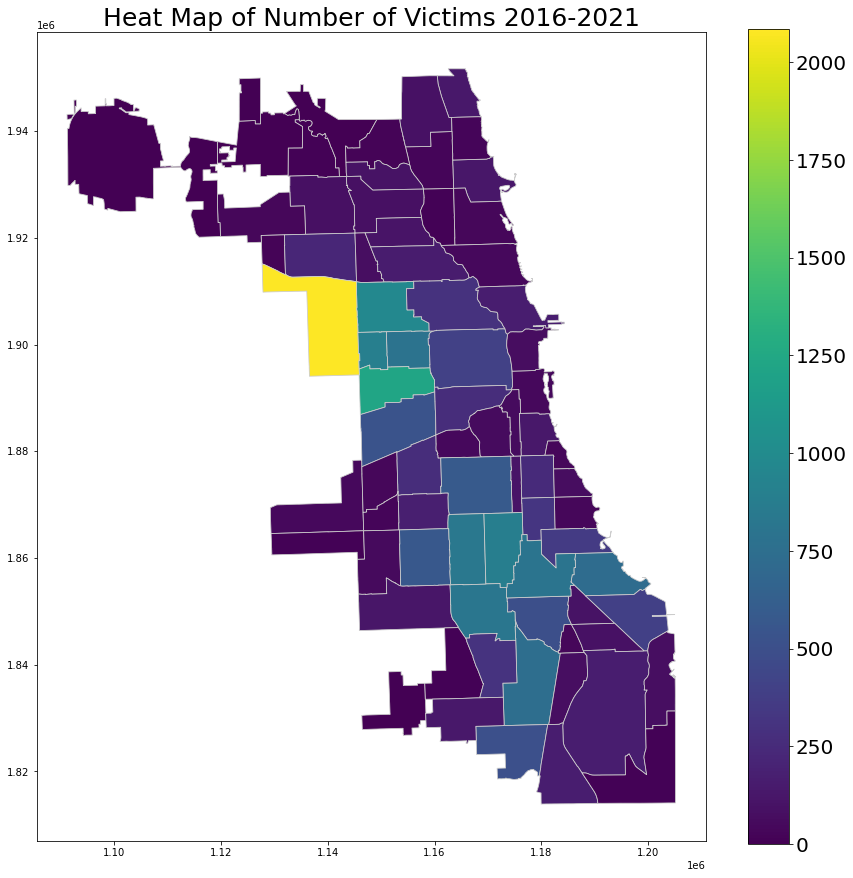

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Heat Map of Number of Victims 2016-2021', fontdict={'fontsize': '25', 'fontweight': '1'})
vmin, vmax = 0, 2086
sc_ma = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sc_ma._A = []
cbar = fig.colorbar(sc_ma)
cbar.ax.tick_params(labelsize=20)
merge_loc.plot('unique_id', linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));

In [24]:
df_dow = df.groupby('day_of_week').count()

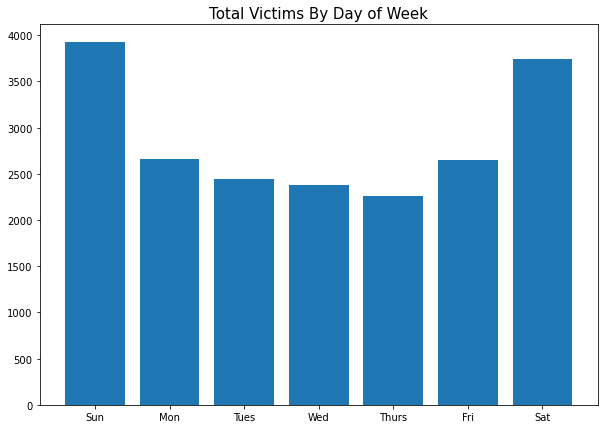

In [25]:
day_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(day_list ,df_dow['unique_id'])
ax.set_title('Total Victims By Day of Week', fontdict={'fontsize': '15'});

# 1 Sun, 2 Mon etc

In [26]:
df_month = df.groupby('month').count()
df_month.reset_index(inplace=True)

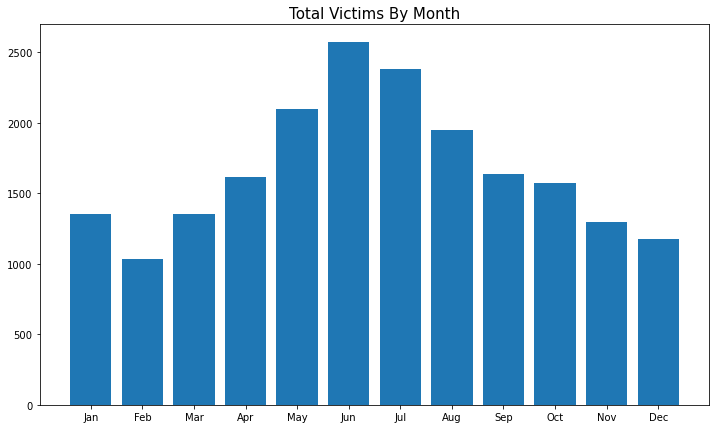

In [27]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12,7))
ax.bar(month_list ,df_month['unique_id'])
ax.set_title('Total Victims By Month', fontdict={'fontsize': '15'});

In [28]:
df_month_year = df.groupby('month_year').count()
df_month_year.reset_index(inplace=True)

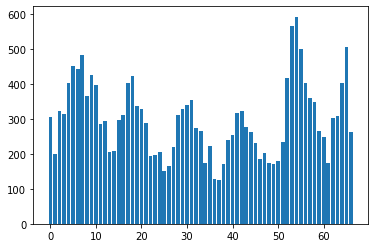

In [29]:
plt.bar(df_month_year.index, df_month_year['unique_id']);

In [30]:
def cat_encoder(category, enc_df):
    ohe = OneHotEncoder(handle_unknown='error', sparse=False)
    
    # 
    temp_df = enc_df[[category]]
    ohe.fit(temp_df)

    cat_encoded = pd.DataFrame(ohe.transform(temp_df).astype(int), \
                               columns=(category+'_'+ohe.categories_[0]))
    return cat_encoded

In [31]:
df['primary_type'].replace(['NON-SHOOTING HOMICIDE', 'FATAL SHOOTING'], 'fatal', inplace=True)
df['primary_type'].replace(['NON-FATAL SHOOTING'], 'non_fatal', inplace=True)

In [32]:
# df = df[df['date'] < '2020-01-01']

In [33]:
df.reset_index(inplace=True)

In [34]:
model_vars = ['date', 'primary_type', 'day_of_week', 'month_year']
model_df = df[model_vars]
model_df = model_df.astype(str)

In [35]:
need_enc = list(model_df.columns[1:])

In [36]:
for col in need_enc:
    loop_df = cat_encoder(str(col), model_df)
    model_df = pd.concat([model_df, loop_df], axis=1)

In [37]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20036 entries, 0 to 20035
Data columns (total 80 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    20036 non-null  object
 1   primary_type            20036 non-null  object
 2   day_of_week             20036 non-null  object
 3   month_year              20036 non-null  object
 4   primary_type_fatal      20036 non-null  int64 
 5   primary_type_non_fatal  20036 non-null  int64 
 6   day_of_week_1           20036 non-null  int64 
 7   day_of_week_2           20036 non-null  int64 
 8   day_of_week_3           20036 non-null  int64 
 9   day_of_week_4           20036 non-null  int64 
 10  day_of_week_5           20036 non-null  int64 
 11  day_of_week_6           20036 non-null  int64 
 12  day_of_week_7           20036 non-null  int64 
 13  month_year_2016-01      20036 non-null  int64 
 14  month_year_2016-02      20036 non-null  int64 
 15  mo

In [38]:
model_df

,date,primary_type,day_of_week,month_year,primary_type_fatal,primary_type_non_fatal,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,month_year_2016-01,month_year_2016-02,month_year_2016-03,month_year_2016-04,month_year_2016-05,month_year_2016-06,month_year_2016-07,month_year_2016-08,month_year_2016-09,month_year_2016-10,month_year_2016-11,month_year_2016-12,month_year_2017-01,month_year_2017-02,month_year_2017-03,month_year_2017-04,month_year_2017-05,month_year_2017-06,month_year_2017-07,month_year_2017-08,month_year_2017-09,month_year_2017-10,month_year_2017-11,month_year_2017-12,month_year_2018-01,month_year_2018-02,month_year_2018-03,month_year_2018-04,month_year_2018-05,month_year_2018-06,month_year_2018-07,month_year_2018-08,month_year_2018-09,month_year_2018-10,month_year_2018-11,month_year_2018-12,month_year_2019-01,month_year_2019-02,month_year_2019-03,month_year_2019-04,month_year_2019-05,month_year_2019-06,month_year_2019-07,month_year_2019-08,month_year_2019-09,month_year_2019-10,month_year_2019-11,month_year_2019-12,month_year_2020-01,month_year_2020-02,month_year_2020-03,month_year_2020-04,month_year_2020-05,month_year_2020-06,month_year_2020-07,month_year_2020-08,month_year_2020-09,month_year_2020-10,month_year_2020-11,month_year_2020-12,month_year_2021-01,month_year_2021-02,month_year_2021-03,month_year_2021-04,month_year_2021-05,month_year_2021-06,month_year_2021-07
0,2016-01-01,fatal,6,2016-01,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016-01-01,fatal,6,2016-01,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016-01-01,fatal,6,2016-01,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016-01-02,fatal,7,2016-01,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016-01-04,fatal,2,2016-01,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20031,2021-06-14,non_fatal,2,2021-06,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
20032,2021-07-03,non_fatal,7,2021-07,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20033,2021-07-04,non_fatal,1,2021-07,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20034,2021-07-06,fatal,3,2021-07,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
model_df = model_df.groupby('date').sum()

In [40]:
def binary_maker(num):
    if num > 0:
        return 1
    else:
        return 0

In [41]:
for col in model_df.columns:
    if 'day' in col or 'month' in col:
        model_df[col] = model_df[col].map(binary_maker)

In [42]:
target = model_df['primary_type_fatal'] + model_df['primary_type_non_fatal'][1:]
target

date
2016-01-01     NaN
2016-01-02     9.0
2016-01-03    12.0
2016-01-04     6.0
2016-01-05    13.0
              ... 
2021-07-09    12.0
2021-07-10    26.0
2021-07-11    11.0
2021-07-12    10.0
2021-07-13    14.0
Length: 2016, dtype: float64

In [43]:
# target = model_df['so_yes_no_yes'] + model_df['so_yes_no_no'][1:]
# target

In [44]:
time_list = []
count_list = []

for col in model_df.columns:
    if 'day' in col or 'month' in col:
        time_list.append(col)
    else:
        count_list.append(col)
        
time_df = model_df[time_list]

In [45]:
for col in time_df:
    time_df[col] = time_df[col].map(binary_maker)

time_df = time_df[2:]

<ipython-input-45-fd6de9be08b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df[col] = time_df[col].map(binary_maker)


In [46]:
# model_df.set_index('date', inplace=True)
model_df = model_df[count_list]
model_df = model_df.rolling(window=2).sum()
model_df = model_df[2:]
model_df = pd.concat([model_df, time_df], axis=1)

In [47]:
model_df.drop('month_year_2016-01', axis=1, inplace=True)
model_df.drop('day_of_week_7', axis=1, inplace=True)

In [48]:
model = LinearRegression()

X = model_df
y = target[2:]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

model.fit(X_train, y_train)

LinearRegression()

In [50]:
model.score(X_train, y_train)

0.7577096188544055

In [51]:
model.score(X_test, y_test)

0.7348394749990343

In [52]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     64.91
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:52:12   Log-Likelihood:                -4039.5
No. Observations:                1611   AIC:                             8229.
Df Residuals:                    1536   BIC:                             8633.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.4520      0.648      3.785      0.000       1.181       3.722
primary_type_fatal         0.4698      0.037     12.598      0.000       0.397       0.543
primary_type_non_fatal     0.4953      0.013     37.877      0.000       0.470       0.521
day_of_week_1             -1.5957      0.288     -5.531      0.000      -2.162      -1.030
day_of_week_2             -4.2058      0.283    -14.880      0.000      -4.760      -3.651
day_of_week_3             -2.1960      0.296     -7.414      0.000      -2.777      -1.615
day_of_week_4             -2.1405      0.287     -7.462      0.000      -2.703      -1.578
day_of_week_5             -2.3589      0.291     -8.115      0.000      -2.929      -1.789
day_of_week_6             -1.4959      0.291     -5.132      0.000      -2.068      -0.924
month_year_2016-02        -0.7184      0.881     -0.815      0.415      -2.446       1.010
month_year_2016-03         0.3466      0.868      0.399      0.690      -1.356       2.049
month_year_2016-04        -0.5833      0.839     -0.696      0.487      -2.228       1.062
month_year_2016-05        -0.4581      0.833     -0.550      0.582      -2.092       1.176
month_year_2016-06         0.4017      0.845      0.475      0.635      -1.256       2.060
month_year_2016-07        -0.4747      0.843     -0.563      0.573      -2.128       1.178
month_year_2016-08        -0.3722      0.866     -0.430      0.668      -2.072       1.327
month_year_2016-09        -0.0528      0.849     -0.062      0.950      -1.718       1.613
month_year_2016-10        -0.3287      0.842     -0.390      0.696      -1.981       1.323
month_year_2016-11        -0.2110      0.870     -0.243      0.808      -1.918       1.495
month_year_2016-12        -0.1506      0.857     -0.176      0.861      -1.832       1.531
month_year_2017-01        -0.7061      0.856     -0.825      0.410      -2.386       0.973
month_year_2017-02        -0.5647      0.858     -0.658      0.510      -2.248       1.118
month_year_2017-03        -0.3474      0.849     -0.409      0.682      -2.012       1.317
month_year_2017-04        -0.2409      0.867     -0.278      0.781      -1.941       1.459
month_year_2017-05        -0.2852      0.829     -0.344      0.731      -1.911       1.341
month_year_2017-06         0.1231      0.883      0.140      0.889      -1.608       1.854
month_year_2017-07        -0.5368      0.826     -0.649      0.516      -2.158       1.084
month_year_2017-08        -0.5292      0.839     -0.631      0.528      -2.175       1.116
month_year_2017-09         0.1258      0.848      0.148      0.882      -1.537       1.789
month_year_2017-10        -0.3310      0.806     -0.411      0.681      -1.913       1.251
month_year_2017-11        -0.2927      0.849     -0.345      0.730      -1.957  

In [53]:
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import cross_validate, ShuffleSplit

# splitter = ShuffleSplit(n_splits=3, test_size=.25, random_state=0)

# model_for_rfecv = LinearRegression()

# selector = RFECV(model_for_rfecv, cv=splitter)
# selector.fit(X_train, y_train)

# print('Column selected?')
# for idx, col in enumerate(X_train.columns):
#     print(f"{col}: {selector.support_[idx]}")

In [54]:
tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)
tree_model.score(X_train, y_train)

0.999198516489663

In [55]:
tree_model.score(X_test, y_test)

0.5538031559430432

In [56]:
dt = DecisionTreeRegressor()

In [57]:
dt.get_params().items()

dict_items([('ccp_alpha', 0.0), ('criterion', 'mse'), ('max_depth', None), ('max_features', None), ('max_leaf_nodes', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('presort', 'deprecated'), ('random_state', None), ('splitter', 'best')])

In [58]:
# Different Hyperparameters
param_grid = {'max_features': [5, 10, 15],
              'max_depth': [4, 5, 6],
             'min_samples_split': [2,3,4]}

In [59]:
gridsearch = GridSearchCV(estimator=dt,
                         param_grid=param_grid,
                         scoring='r2',
                         cv=10)

In [60]:
gridsearch.fit(X_train, y_train)

gridsearch.score(X_test, y_test)

0.496126416246802

In [61]:
gridsearch.best_estimator_

DecisionTreeRegressor(max_depth=6, max_features=15, min_samples_split=3)

In [62]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
pca2 = PCA(n_components=5)

xpca1 = pca1.fit_transform(X_train)
xpca2 = pca2.fit_transform(X_train)

print(np.sum(pca1.explained_variance_ratio_))
print(np.sum(pca2.explained_variance_ratio_))


0.9806989650430885
0.9857270927237132


In [63]:
pipe = Pipeline([('pca', PCA(n_components=10)),
                ('sgd', SGDRegressor())])

In [64]:
pipe.fit(X_train, y_train)

pipe.score(X_train, y_train)

0.7420147783493066

In [65]:
pipe.score(X_test, y_test)

0.7422229934974262

In [66]:
pipe.get_params()

{'memory': None,
 'steps': [('pca', PCA(n_components=10)), ('sgd', SGDRegressor())],
 'verbose': False,
 'pca': PCA(n_components=10),
 'sgd': SGDRegressor(),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 10,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'sgd__alpha': 0.0001,
 'sgd__average': False,
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.01,
 'sgd__fit_intercept': True,
 'sgd__l1_ratio': 0.15,
 'sgd__learning_rate': 'invscaling',
 'sgd__loss': 'squared_loss',
 'sgd__max_iter': 1000,
 'sgd__n_iter_no_change': 5,
 'sgd__penalty': 'l2',
 'sgd__power_t': 0.25,
 'sgd__random_state': None,
 'sgd__shuffle': True,
 'sgd__tol': 0.001,
 'sgd__validation_fraction': 0.1,
 'sgd__verbose': 0,
 'sgd__warm_start': False}

In [67]:
sgd_param_grid = {'pca__n_components': [10, 15, 20],
                  'sgd__alpha': [.001, .0001, .00001],
                 'sgd__epsilon': [.1, .01, .001],
                 'sgd__n_iter_no_change': [5,6,7]}

In [68]:
sgd_cv = GridSearchCV(estimator=pipe,
                     param_grid=sgd_param_grid,
                     scoring='r2',
                     cv=10)

In [69]:
sgd_cv.fit(X_train, y_train)

sgd_cv.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=20)),
                ('sgd',
                 SGDRegressor(alpha=0.001, epsilon=0.001, n_iter_no_change=7))])

In [70]:
sgd_cv.score(X_test, y_test)

0.6842700328905199